# Advanced Macroeconomics 1: Homework 3

## Settings

In [1]:
######################################################
# 📦 Package Imports
######################################################

# === Data Manipulation ===
import pandas as pd                # DataFrame handling
import numpy as np                # Numerical operations
import random                     # For reproducibility

# === Visualization ===
import matplotlib.pyplot as plt   # General plotting
import seaborn as sns             # Statistical visualization

# === Time Series & Statistical Models ===
import statsmodels.api as sm
from statsmodels.tsa.stattools import (
    adfuller,                     # Augmented Dickey-Fuller Test
    kpss,                         # KPSS Test
    acf, pacf                     # Autocorrelation functions
)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import (
    plot_acf,                     # ACF plot
    plot_pacf                     # PACF plot
)
from statsmodels.stats.diagnostic import acorr_ljungbox  # Ljung-Box test
from statsmodels.tsa.api import VAR                      # VAR model
from arch.unitroot import PhillipsPerron, ZivotAndrews   # Unit root tests

# === Machine Learning Metrics ===
from sklearn.metrics import mean_squared_error           # Model evaluation

# === Optional External Data Sources ===
import ipeadatapy as ipea                                # IPEA database (optional)

# === Utilities ===
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# === Reproducibility ===
seed = 42
np.random.seed(seed)
random.seed(seed)

# === Custom Color ===
red_color = (162 / 255, 37 / 255, 56 / 255)




In [2]:
warnings.filterwarnings("ignore")

## Questions

### Question 1

Obtain the monthly time series for the following variables: IPCA inflation, IBC-Br (series 24363 from the Brazilian Central Bank), SELIC interest rate, commodity price index (series 27574 from the Central Bank), and the exchange rate. Construct a measure of the real interest rate using the IPCA as the deflator. Use data starting from January 2000.

With these series, estimate a Vector Autoregression (VAR) model using monthly data, imposing a recursive identification scheme (Cholesky decomposition). The ordering of the variables in the VAR should be as follows: IPCA inflation, real interest rate (constructed), commodity price index, IBC-Br, and exchange rate.

#### Data

In [3]:
# Here we use a keyword to search for available time series or browse them manually on the IPEA website
ipea.metadata()

,CODE,NAME,COMMENT,LAST UPDATE,BIG THEME,SOURCE ACRONYM,SOURCE,SOURCE URL,FREQUENCY,MEASURE,UNIT,SERIES STATUS,THEME CODE,COUNTRY,NUMERICA
0,ABATE_ABPEAV,Abate - aves - peso das carcaças,O abate de animais é mensurado por sua quantid...,2025-03-18T13:00:00.673-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Anual,Tonelada,mil,A,1,BRA,True
1,ABATE_ABQUBV,Abate - bovinos - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T13:00:00.673-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Anual,Cabeça,mil,A,1,BRA,True
2,ABATE12_ABPEVA12,Abate - vacas - peso das carcaças,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Tonelada,mil,I,1,BRA,True
3,ABATE12_ABQUBO12,Abate - bois - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Cabeça,mil,A,1,BRA,True
4,ABATE12_ABQUBV12,Abate - bovinos - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Cabeça,mil,A,1,BRA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804,PNADCT_TXPARTCUF_SI,Taxa de participação - sem instrução ou equiva...,"Taxa de participação na força de trabalho, na ...",2025-02-18T12:24:51.957-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Trimestral,(%),None,None,110,None,True
2805,PNAD_IAGRV,Domicílios com insegurança alimentar grave,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.677-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True
2806,PNAD_IALEV,Domicílios com insegurança alimentar leve,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.68-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True
2807,PNAD_IAMOD,Domicílios com insegurança alimentar moderada,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.683-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True


In [4]:
# IPCA series

# Downloading the IPCA series from IPEA
df_ipca = ipea.timeseries('PRECOS12_IPCA12')

# Renaming columns for clarity
df_ipca = df_ipca.rename(columns={
    'RAW DATE': 'date',
    'VALUE (-)': 'IPCA',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Drop unnecessary columns
df_ipca = df_ipca.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Convert 'date' column to datetime (with timezone awareness handling)
df_ipca['date'] = pd.to_datetime(df_ipca['date'], errors='coerce', utc=True)

# Set 'date' as index
df_ipca.set_index('date', inplace=True)

# Remove timezone to make index tz-naive (match other DataFrames)
df_ipca.index = df_ipca.index.tz_convert(None)
df_ipca.index = df_ipca.index.to_period('M').to_timestamp()

# Sort by date
df_ipca = df_ipca.sort_index()

# Calculate monthly inflation from IPCA index
df_ipca['monthly_inflation'] = df_ipca['IPCA'] / df_ipca['IPCA'].shift(1) - 1

df_ipca['monthly_inflation'] = df_ipca['monthly_inflation'].round(5)
df_ipca['IPCA'] = df_ipca['IPCA'].round(5)

# Preview
df_ipca.head()


,IPCA,monthly_inflation
date,,
1979-12-01,0.0,NaN
1980-01-01,0.0,0.06616
1980-02-01,0.0,0.04617
1980-03-01,0.0,0.06038
1980-04-01,0.0,0.05286


In [7]:
# IBC-Br series

# Defining the series code and the date range
series_code = 24363
start_date = '01/01/2000'
end_date = '31/12/2025'

# Building the API URL
url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{series_code}/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'

# Reading the JSON data directly from the API
df_ibcbr = pd.read_json(url)

# Converting the 'date' column to datetime format
df_ibcbr['date'] = pd.to_datetime(df_ibcbr['data'], format='%d/%m/%Y')

# Converting the 'valor' column to numeric type
df_ibcbr['valor'] = pd.to_numeric(df_ibcbr['valor'], errors='coerce')

# Renaming columns for clarity
df_ibcbr = df_ibcbr.rename(columns={
    'valor': 'IBC-Br',
})

# Drop columns
df_ibcbr = df_ibcbr.drop(columns=['data'], errors='ignore')

# Setting 'date' as the index
df_ibcbr.set_index('date', inplace=True)
df_ibcbr.index = df_ibcbr.index.to_period('M').to_timestamp()

# Calculate monthly variation
df_ibcbr['delta_IBCBR'] = df_ibcbr['IBC-Br'] / df_ibcbr['IBC-Br'].shift(1) - 1

df_ibcbr['IBC-Br'] = df_ibcbr['IBC-Br'].round(5)
df_ibcbr['delta_IBCBR'] = df_ibcbr['delta_IBCBR'].round(5)

# Preview
df_ibcbr.head()

,IBC-Br,delta_IBCBR
date,,
2003-01-01,67.44572,NaN
2003-02-01,69.20861,0.02614
2003-03-01,72.53661,0.04809
2003-04-01,71.67673,-0.01185
2003-05-01,70.35122,-0.01849


In [8]:
# SELIC Acum series

# Downloading the SELIC series from IPEA
df_selic = ipea.timeseries('BM12_TJOVER12')

# Renaming columns for clarity
df_selic = df_selic.rename(columns={
    'RAW DATE': 'date',
    'VALUE ((% a.m.))': 'SELIC',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Dropping unnecessary columns
df_selic = df_selic.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Converting 'date' column to datetime (handling timezone if needed)
df_selic['date'] = pd.to_datetime(df_selic['date'], errors='coerce', utc=True)

# Setting 'date' as the index
df_selic.set_index('date', inplace=True)

# Removing timezone to make the index tz-naive
df_selic.index = df_selic.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_selic.index = df_selic.index.to_period('M').to_timestamp()

# Sorting the DataFrame by date
df_selic = df_selic.sort_index()

# Convert SELIC to decimal
df_selic['selic_dec'] = df_selic['SELIC'] / 100

df_selic['SELIC'] = df_selic['SELIC'].round(5)
df_selic['selic_dec'] = df_selic['selic_dec'].round(5)

# Preview
df_selic.head()


,SELIC,selic_dec
date,,
1974-01-01,1.46,0.0146
1974-02-01,1.15,0.0115
1974-03-01,1.16,0.0116
1974-04-01,1.21,0.0121
1974-05-01,1.24,0.0124


In [9]:
# Commodity price index series

commodity_code = 27574
start_date = '01/01/2000'
end_date = '31/12/2025'

# Building the API URL
url_commodity = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{commodity_code}/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'

# Reading the data from the API
df_commodity = pd.read_json(url_commodity)

# Converting 'data' to datetime and 'valor' to numeric
df_commodity['data'] = pd.to_datetime(df_commodity['data'], format='%d/%m/%Y', utc=True)
df_commodity['valor'] = pd.to_numeric(df_commodity['valor'], errors='coerce')

# Renaming columns for clarity
df_commodity = df_commodity.rename(columns={'data': 'date', 'valor': 'Commodity_Price_Index'})

# Setting date as index
df_commodity.set_index('date', inplace=True)

# Removing timezone to make index tz-naive
df_commodity.index = df_commodity.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_commodity.index = df_commodity.index.to_period('M').to_timestamp()

# Sorting by date
df_commodity = df_commodity.sort_index()


# Calculate monthly inflation from IPCA index
df_commodity['monthly_Commodity_inflation'] = df_commodity['Commodity_Price_Index'] / df_commodity['Commodity_Price_Index'].shift(1) - 1

df_commodity['Commodity_Price_Index'] = df_commodity['Commodity_Price_Index'].round(5)
df_commodity['monthly_Commodity_inflation'] = df_commodity['monthly_Commodity_inflation'].round(5)

# Preview
df_commodity.head()


,Commodity_Price_Index,monthly_Commodity_inflation
date,,
2000-01-01,51.41,NaN
2000-02-01,50.22,-0.02315
2000-03-01,49.51,-0.01414
2000-04-01,50.31,0.01616
2000-05-01,53.18,0.05705


In [10]:
# Exchange rate series code (Dollar - commercial rate, selling)

# Downloading the series from IPEA
df_fx = ipea.timeseries('PAN12_ERV12')

# Renaming columns for clarity
df_fx = df_fx.rename(columns={
    'RAW DATE': 'date',
    'VALUE (R$)': 'FX_Rate',  # Corrigido! Estava escrito 'SELIC' por engano
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Dropping unnecessary columns
df_fx = df_fx.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Converting 'date' to datetime with timezone handling
df_fx['date'] = pd.to_datetime(df_fx['date'], errors='coerce', utc=True)

# Setting 'date' as index
df_fx.set_index('date', inplace=True)

# Removing timezone to make index tz-naive
df_fx.index = df_fx.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_fx.index = df_fx.index.to_period('M').to_timestamp()

# Sorting by date
df_fx = df_fx.sort_index()

# Calculate monthly inflation from IPCA index
df_fx['delta_FX_Rate'] = df_fx['FX_Rate'] / df_fx['FX_Rate'].shift(1) - 1

df_fx['FX_Rate'] = df_fx['FX_Rate'].round(5)
df_fx['delta_FX_Rate']  = df_fx['delta_FX_Rate'] .round(5)


# Preview
df_fx.head()

,FX_Rate,delta_FX_Rate
date,,
1930-01-01,0.0,NaN
1930-02-01,0.0,0.00000
1930-03-01,0.0,-0.03333
1930-04-01,0.0,-0.02299
1930-05-01,0.0,0.00000


In [11]:
df = df_ibcbr.join([df_ipca, df_selic, df_commodity, df_fx], how='inner')

In [12]:
# Calculate real interest rate using exact Fisher formula
df['real_interest_rate'] = (1 + df['selic_dec']) / (1 + df['monthly_inflation']) - 1

df['real_interest_rate']  = df['real_interest_rate'].round(5)

In [13]:
# Select the variables of interest for the VAR
vars_var = df[['monthly_inflation', 'real_interest_rate', 'Commodity_Price_Index', 'IBC-Br', 'FX_Rate']]

# Check how many missing values there are in each column
print(vars_var.isna().sum())

monthly_inflation        0
real_interest_rate       0
Commodity_Price_Index    0
IBC-Br                   0
FX_Rate                  0
dtype: int64


#### Plot series

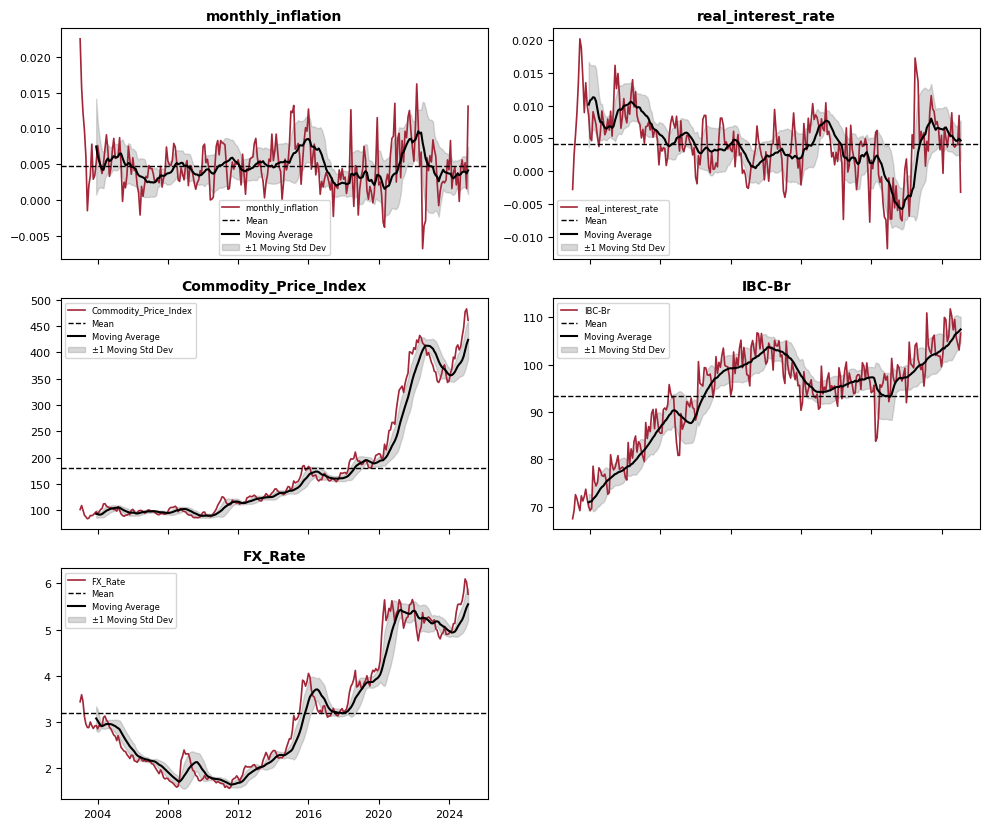

In [14]:
# Graph
window_size = 12
cols = vars_var.columns
n_vars = len(cols)
n_cols = 2  # Number of plots per row
n_rows = (n_vars + 1) // n_cols  # Number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 2.8 * n_rows), sharex=True)
axes = axes.flatten()

for i, column in enumerate(cols):
    
    ax = axes[i]
    
    # Calculate moving average and moving standard deviation
    moving_mean = vars_var[column].rolling(window=window_size).mean()
    moving_std = vars_var[column].rolling(window=window_size).std()
    
    # Mean and std of entire series
    mean_value = vars_var[column].mean()
    std_dev = vars_var[column].std()
    
    # Plot
    ax.plot(vars_var.index, vars_var[column], color=red_color, linewidth=1.2, label=f"{column}")
    ax.axhline(mean_value, color='black', linestyle='--', linewidth=1, label='Mean')
    ax.plot(vars_var.index, moving_mean, color='black', linestyle='-', linewidth=1.5, label="Moving Average")
    ax.fill_between(vars_var.index, 
                    moving_mean - moving_std, 
                    moving_mean + moving_std, 
                    color='grey', alpha=0.3, label='±1 Moving Std Dev')
    
    ax.set_title(f"{column}", fontsize=10, fontweight='bold')
    ax.tick_params(axis='both', labelsize=8)
    ax.legend(fontsize=6, loc='best')
    ax.set_xlabel("")
    ax.set_ylabel("")

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Choose lags for VAR model based on AIC, SBC, and HQ criteria

In [16]:
# Fit VAR model
model = VAR(vars_var)

# Initialize dictionaries to store info criteria for each lag
aic_dict = {}
bic_dict = {}
hqic_dict = {}

# Test lags from 1 to 15
for lag in range(1, 16):
    result = model.fit(lag)
    aic_dict[lag] = result.aic
    bic_dict[lag] = result.bic
    hqic_dict[lag] = result.hqic

# Create DataFrame with all criteria
criteria_table = pd.DataFrame({
    'AIC': pd.Series(aic_dict),
    'BIC': pd.Series(bic_dict),
    'HQIC': pd.Series(hqic_dict)
})

print("Information Criteria by Lag:")
print(criteria_table)

# Find which lag each criterion selected
selected_orders = {
    'aic': criteria_table['AIC'].idxmin(),
    'bic': criteria_table['BIC'].idxmin(),
    'hqic': criteria_table['HQIC'].idxmin()
}

print("\nLag selected by each criterion:")
print(selected_orders)

# Count how many times each lag was selected
criteria_counts = Counter(selected_orders.values())
print("\nLag chosen by multiple criteria:")
print(criteria_counts)

# Choose the most common lag
most_common_lag = criteria_counts.most_common(1)[0][0]
print(f"\nFinal selected lag: {most_common_lag}")

# Fit final VAR model
results = model.fit(most_common_lag)


Information Criteria by Lag:
          AIC        BIC       HQIC
1  -24.112015 -23.706763 -23.949191
2  -24.576347 -23.831357 -24.276987
3  -24.827729 -23.741142 -24.391055
4  -24.943817 -23.513755 -24.369044
5  -24.985244 -23.209812 -24.271578
6  -25.117341 -22.994627 -24.263982
7  -25.377620 -22.905693 -24.383760
8  -25.427011 -22.603923 -24.291834
9  -25.471057 -22.294841 -24.193740
10 -25.544863 -22.013534 -24.124576
11 -25.801713 -21.913267 -24.237617
12 -25.993326 -21.745739 -24.284574
13 -26.060399 -21.451630 -24.206136
14 -26.027207 -21.055194 -24.026572
15 -26.180168 -20.842829 -24.032289

Lag selected by each criterion:
{'aic': np.int64(15), 'bic': np.int64(2), 'hqic': np.int64(3)}

Lag chosen by multiple criteria:
Counter({np.int64(15): 1, np.int64(2): 1, np.int64(3): 1})

Final selected lag: 15


#### Estimate the VAR model and perform the diagnostic/specification tests as discussed in class.

In [41]:

# Select variables and drop missing values
cols = ['monthly_inflation', 'real_interest_rate', 'Commodity_Price_Index', 'IBC-Br', 'FX_Rate']
df_var = df[cols].dropna()

# Estimate VAR(12) model using OLS
model = VAR(df_var)
results = model.fit(12, method='ols')

# Print summary
print(results.summary())



  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           dom, 11, mai, 2025
Time:                     20:40:28
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -21.7457
Nobs:                     254.000    HQIC:                  -24.2846
Log likelihood:           1804.10    FPE:                5.39532e-12
AIC:                     -25.9933    Det(Omega_mle):     1.83922e-12
--------------------------------------------------------------------
Results for equation monthly_inflation
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             0.003014         0.004356            0.692           0.489
L1.monthly_inflation              0.673859         0.314849            2.140           0.032


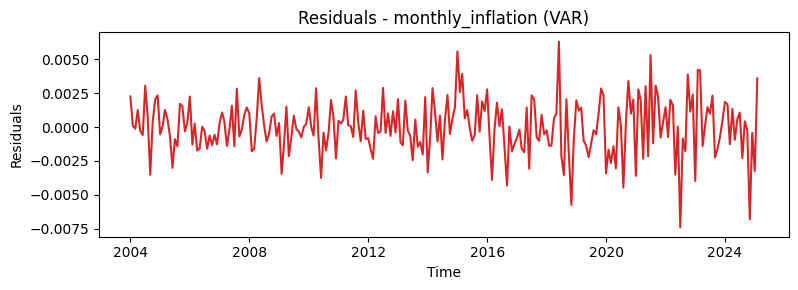

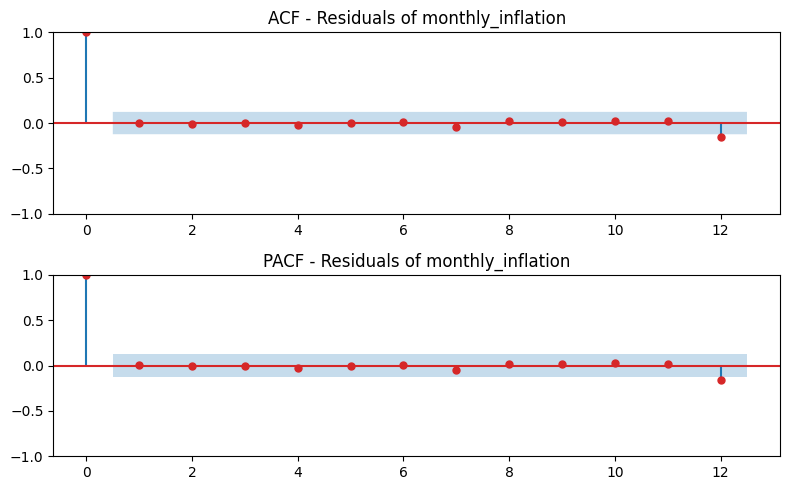

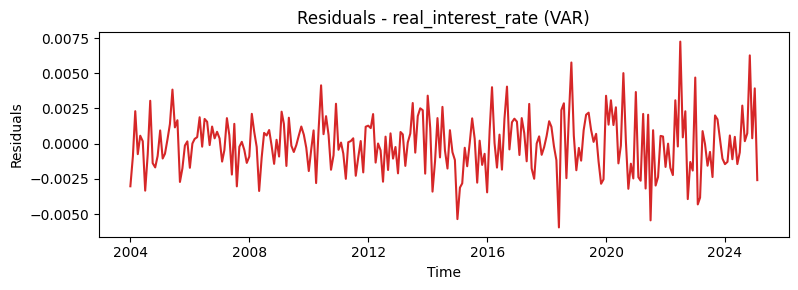

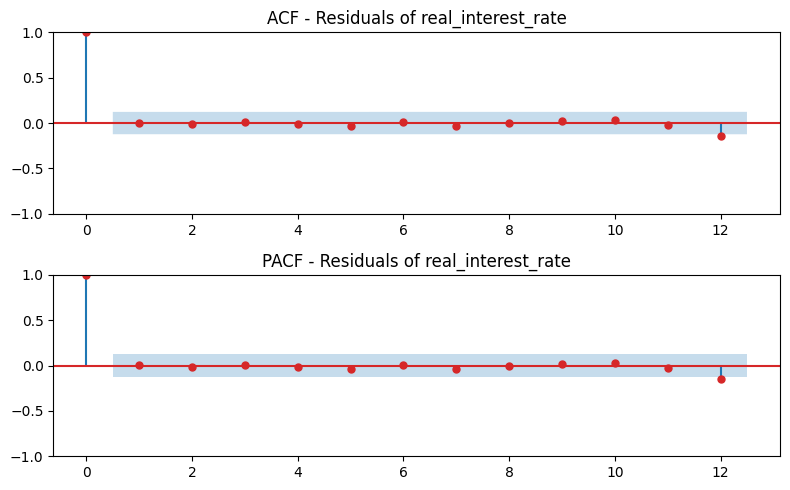

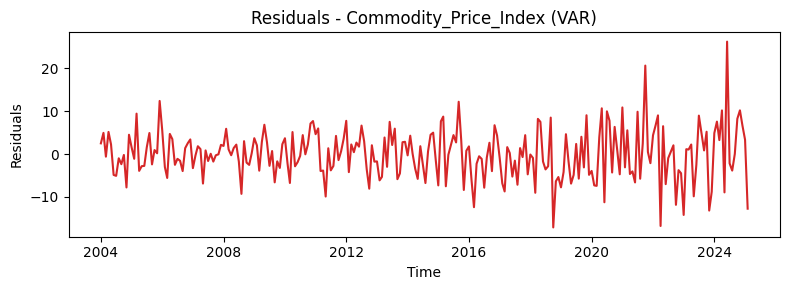

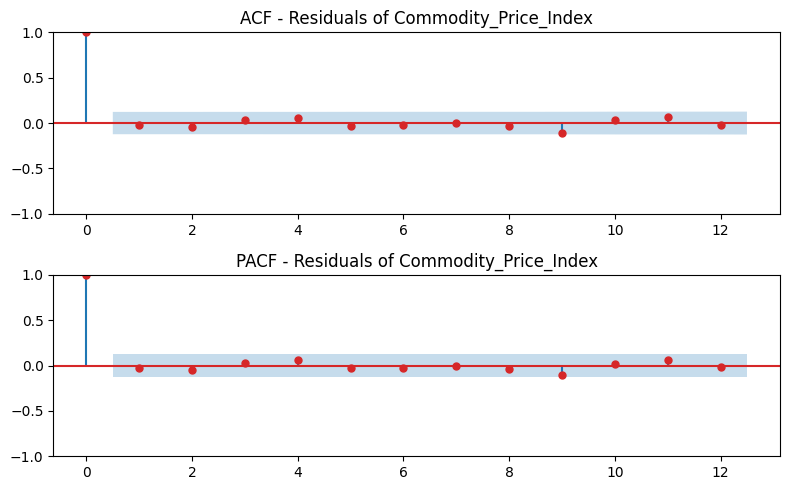

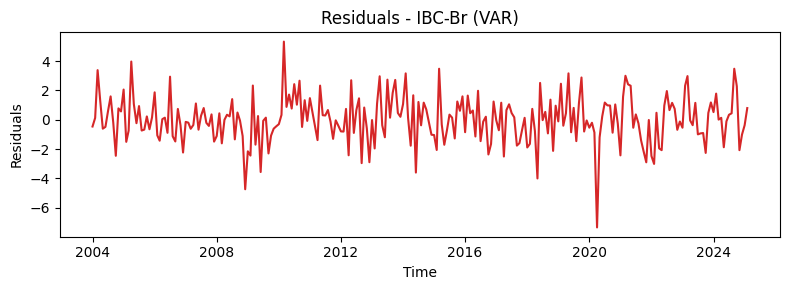

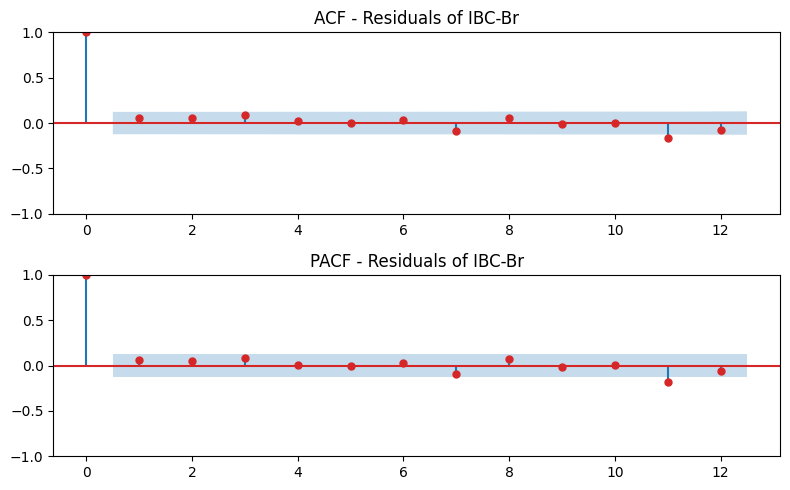

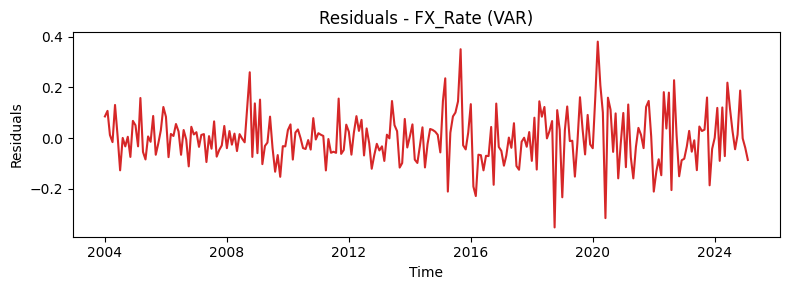

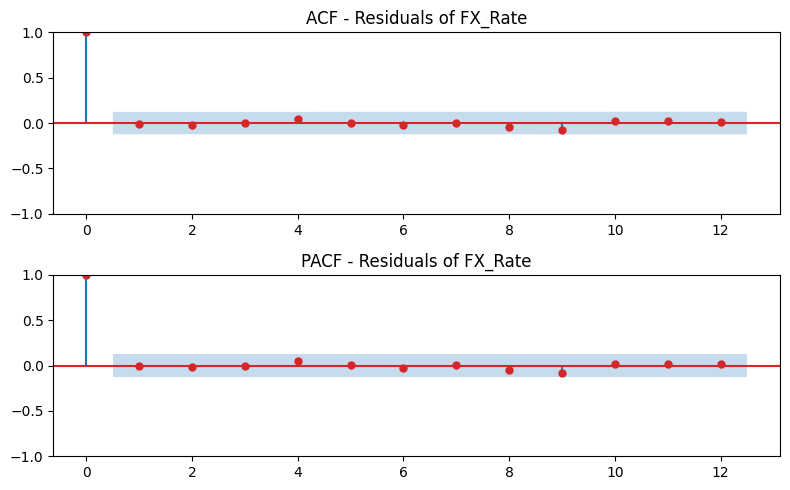

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def plot_var_diagnostics(model, variables, lags=12, color="#d62728"):
    """
    Plot residuals, ACF, and PACF for each endogenous variable in a VAR model.

    Parameters:
    - model: fitted VAR model
    - variables: list of variable names
    - lags: number of lags for ACF/PACF plots
    - color: color for plots (default is red)
    """
    for var in variables:
        residuals = model.resid[var].dropna()

        # Residual plot
        plt.figure(figsize=(8, 3))
        plt.plot(residuals, color=color)
        plt.title(f"Residuals - {var} (VAR)")
        plt.xlabel("Time")
        plt.ylabel("Residuals")
        plt.tight_layout()
        plt.show()

        # ACF and PACF plots
        fig, axs = plt.subplots(2, 1, figsize=(8, 5))
        plot_acf(residuals, lags=lags, ax=axs[0], color=color)
        axs[0].set_title(f"ACF - Residuals of {var}")
        plot_pacf(residuals, lags=lags, ax=axs[1], color=color)
        axs[1].set_title(f"PACF - Residuals of {var}")
        plt.tight_layout()
        plt.show()

# Example usage:
variables = ['monthly_inflation', 'real_interest_rate', 'Commodity_Price_Index', 'IBC-Br', 'FX_Rate']
plot_var_diagnostics(model_mle, variables)


In [45]:

port_test = results.test_whiteness(nlags=13)


p_value = port_test.pvalue


if p_value < 0.05:
    print(f"❌ Residuals fail Portmanteau test: serial correlation detected (p = {p_value:.3f})")
else:
    print(f"✅ Residuals pass Portmanteau test: no serial correlation detected (p = {p_value:.3f})")

print("\nFull test results:")
print(port_test.summary())


❌ Residuals fail Portmanteau test: serial correlation detected (p = 0.000)

Full test results:
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 13 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         184.2          37.65   0.000 25
----------------------------------------


In [46]:
from statsmodels.stats.diagnostic import acorr_lm

print("Breusch-Godfrey (LM) Test for Serial Correlation in Residuals (lag = 12)\n")

# Loop over each equation in the VAR
for var in results.names:
    resids = results.resid[var]  # residuals for the equation
    lm_stat, lm_pvalue, _, _ = acorr_lm(resids, nlags=12)
    
    # Interpret result
    if lm_pvalue < 0.05:
        print(f"❌ {var}: Serial correlation detected (LM test p = {lm_pvalue:.3f})")
    else:
        print(f"✅ {var}: No serial correlation (LM test p = {lm_pvalue:.3f})")


Breusch-Godfrey (LM) Test for Serial Correlation in Residuals (lag = 12)

✅ monthly_inflation: No serial correlation (LM test p = 0.755)
✅ real_interest_rate: No serial correlation (LM test p = 0.852)
✅ Commodity_Price_Index: No serial correlation (LM test p = 0.908)
✅ IBC-Br: No serial correlation (LM test p = 0.208)
✅ FX_Rate: No serial correlation (LM test p = 0.997)


#### Impose a recursive identification. If you have doubts about the ordering, consult Christiano, Eichenbaum, and Evans (1999) or CEE (2005). Justify the ordering.

Recursive Identification Ordering Justification (Cholesky Decomposition)

We use a recursive (Cholesky) identification scheme to orthogonalize the structural shocks in the VAR. The ordering of variables reflects economic reasoning regarding their contemporaneous interactions:

IBC-Br (economic activity) is placed first, assuming that real output does not respond contemporaneously to other shocks within the same month due to inertia in production and investment decisions.

Commodity Price Index is ordered second, as global commodity prices can be influenced by real activity but are largely determined in international markets and are unlikely to respond immediately to domestic monetary shocks.

FX Rate comes third, as exchange rates may respond quickly to changes in economic activity or commodity prices, but not necessarily to domestic monetary policy within the same month.

Monthly Inflation is ordered fourth, acknowledging that prices are sticky and typically adjust with a lag; therefore, inflation does not react contemporaneously to shocks in interest rates.

Real Interest Rate is ordered last, under the assumption that monetary policy responds contemporaneously to all other variables, reflecting a central bank that monitors the state of the economy and adjusts rates accordingly.

This ordering is consistent with standard practice in monetary VAR literature and allows us to interpret the last shock as a monetary policy innovation.

#### Obtain the IRFs for a 36-month horizon with a confidence interval of 68% or 90%. Choose the method to obtain the CI for the IRF. Explain your results. In particular, what are the effects of a monetary policy shock on the economy? Any strange results?

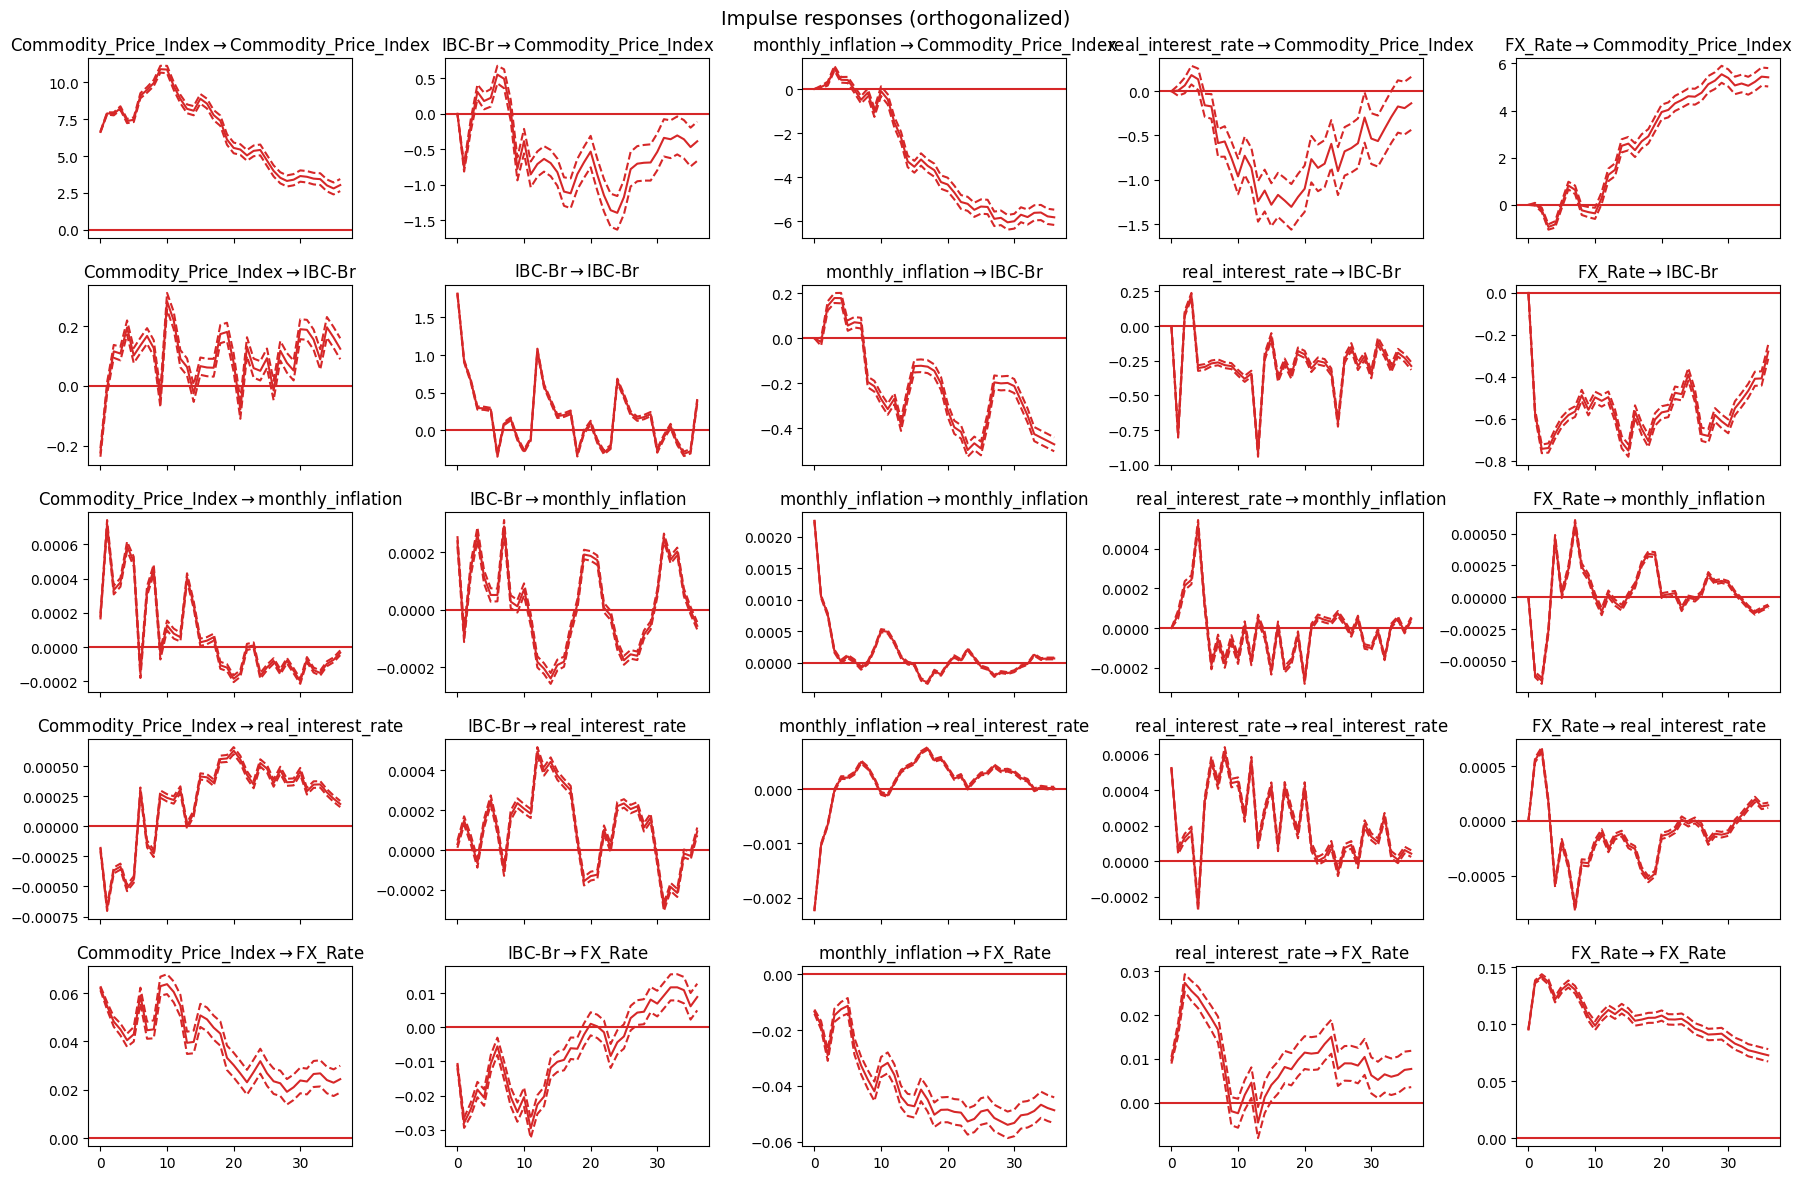

In [47]:
# Variable ordering for Cholesky identification
ordering = ['Commodity_Price_Index', 'IBC-Br','monthly_inflation','real_interest_rate','FX_Rate']

# Reorder the model based on Cholesky decomposition
model_ordered = model_mle.reorder(ordering)

# Generate IRFs for a 36-month horizon with 90% confidence intervals
irf = model_ordered.irf(36)

# Plot with red color and larger figure size
fig = irf.plot(orth=True, signif=0.9)
for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color("#d62728")  # red color

fig.set_size_inches(18, 12)  # increase figure size for clarity
plt.tight_layout()
plt.show()

In [52]:
print("FEVD shape:", fevd.decomp.shape)


FEVD shape: (5, 36, 5)


#### Obtain the FEVD for 2, 6, 12, 18, 24, 36 months. What is the importance of monetary policy?

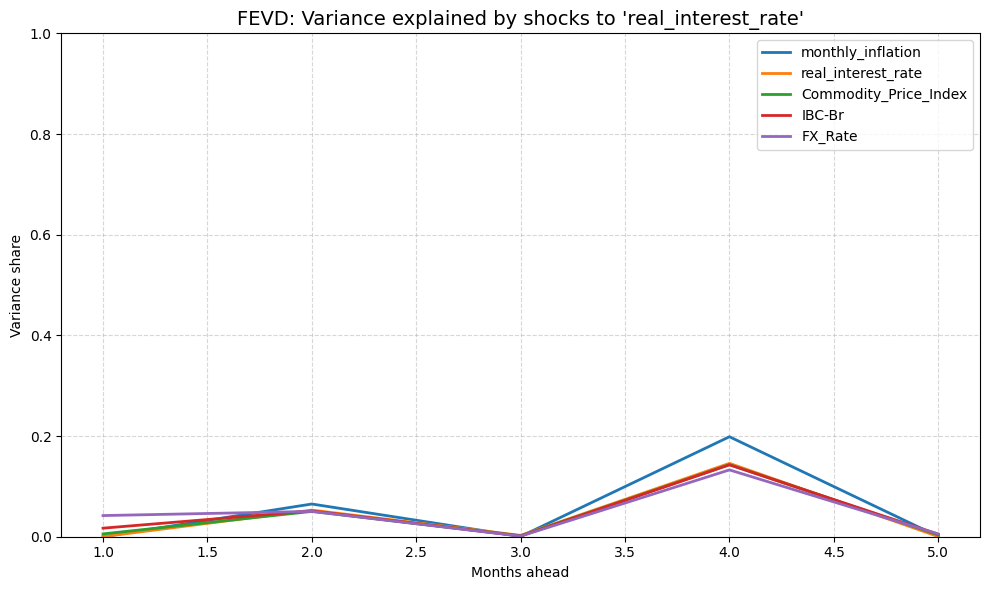

In [54]:
# 
fevd = results.fevd(36)
variables = results.names
shock_var = 'real_interest_rate'
shock_idx = variables.index(shock_var)

# 
T = fevd.decomp.shape[0]
horizon_range = np.arange(1, T + 1)

# Plot
plt.figure(figsize=(10, 6))
for i, var in enumerate(variables):
    contributions = fevd.decomp[:, i, shock_idx]
    plt.plot(horizon_range, contributions, label=var, linewidth=2)

plt.title("FEVD: Variance explained by shocks to 'real_interest_rate'", fontsize=14)
plt.xlabel("Months ahead")
plt.ylabel("Variance share")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


### Question 2

Reestimate the VAR imposing sign restrictions. You must use Inflation (IPCA), real interest rate (the one you constructed), commodity price index, IBC-Br, and exchange rate. You may use either Uhlig (2005), Mountford and Uhlig (2009), or Arias et al. (2018) as a reference. Just choose one method and no need to explain it.

#### Data

In [55]:
# Here we use a keyword to search for available time series or browse them manually on the IPEA website
ipea.metadata()

,CODE,NAME,COMMENT,LAST UPDATE,BIG THEME,SOURCE ACRONYM,SOURCE,SOURCE URL,FREQUENCY,MEASURE,UNIT,SERIES STATUS,THEME CODE,COUNTRY,NUMERICA
0,ABATE_ABPEAV,Abate - aves - peso das carcaças,O abate de animais é mensurado por sua quantid...,2025-03-18T13:00:00.673-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Anual,Tonelada,mil,A,1,BRA,True
1,ABATE_ABQUBV,Abate - bovinos - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T13:00:00.673-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Anual,Cabeça,mil,A,1,BRA,True
2,ABATE12_ABPEVA12,Abate - vacas - peso das carcaças,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Tonelada,mil,I,1,BRA,True
3,ABATE12_ABQUBO12,Abate - bois - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Cabeça,mil,A,1,BRA,True
4,ABATE12_ABQUBV12,Abate - bovinos - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Cabeça,mil,A,1,BRA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804,PNADCT_TXPARTCUF_SI,Taxa de participação - sem instrução ou equiva...,"Taxa de participação na força de trabalho, na ...",2025-02-18T12:24:51.957-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Trimestral,(%),None,None,110,None,True
2805,PNAD_IAGRV,Domicílios com insegurança alimentar grave,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.677-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True
2806,PNAD_IALEV,Domicílios com insegurança alimentar leve,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.68-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True
2807,PNAD_IAMOD,Domicílios com insegurança alimentar moderada,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.683-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True


In [56]:
# IPCA series

# Downloading the IPCA series from IPEA
df_ipca = ipea.timeseries('PRECOS12_IPCA12')

# Renaming columns for clarity
df_ipca = df_ipca.rename(columns={
    'RAW DATE': 'date',
    'VALUE (-)': 'IPCA',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Drop unnecessary columns
df_ipca = df_ipca.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Convert 'date' column to datetime (with timezone awareness handling)
df_ipca['date'] = pd.to_datetime(df_ipca['date'], errors='coerce', utc=True)

# Set 'date' as index
df_ipca.set_index('date', inplace=True)

# Remove timezone to make index tz-naive (match other DataFrames)
df_ipca.index = df_ipca.index.tz_convert(None)
df_ipca.index = df_ipca.index.to_period('M').to_timestamp()

# Sort by date
df_ipca = df_ipca.sort_index()

# Calculate monthly inflation from IPCA index
df_ipca['monthly_inflation'] = df_ipca['IPCA'] / df_ipca['IPCA'].shift(1) - 1

df_ipca['monthly_inflation'] = df_ipca['monthly_inflation'].round(5)
df_ipca['IPCA'] = df_ipca['IPCA'].round(5)

# Preview
df_ipca.head()


,IPCA,monthly_inflation
date,,
1979-12-01,0.0,NaN
1980-01-01,0.0,0.06616
1980-02-01,0.0,0.04617
1980-03-01,0.0,0.06038
1980-04-01,0.0,0.05286


In [57]:
# IBC-Br series

# Defining the series code and the date range
series_code = 24363
start_date = '01/01/2000'
end_date = '31/12/2025'

# Building the API URL
url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{series_code}/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'

# Reading the JSON data directly from the API
df_ibcbr = pd.read_json(url)

# Converting the 'date' column to datetime format
df_ibcbr['date'] = pd.to_datetime(df_ibcbr['data'], format='%d/%m/%Y')

# Converting the 'valor' column to numeric type
df_ibcbr['valor'] = pd.to_numeric(df_ibcbr['valor'], errors='coerce')

# Renaming columns for clarity
df_ibcbr = df_ibcbr.rename(columns={
    'valor': 'IBC-Br',
})

# Drop columns
df_ibcbr = df_ibcbr.drop(columns=['data'], errors='ignore')

# Setting 'date' as the index
df_ibcbr.set_index('date', inplace=True)
df_ibcbr.index = df_ibcbr.index.to_period('M').to_timestamp()

# Calculate monthly variation
df_ibcbr['delta_IBCBR'] = df_ibcbr['IBC-Br'] / df_ibcbr['IBC-Br'].shift(1) - 1

df_ibcbr['IBC-Br'] = df_ibcbr['IBC-Br'].round(5)
df_ibcbr['delta_IBCBR'] = df_ibcbr['delta_IBCBR'].round(5)

# Preview
df_ibcbr.head()

,IBC-Br,delta_IBCBR
date,,
2003-01-01,67.44572,NaN
2003-02-01,69.20861,0.02614
2003-03-01,72.53661,0.04809
2003-04-01,71.67673,-0.01185
2003-05-01,70.35122,-0.01849


In [58]:
# SELIC Acum series

# Downloading the SELIC series from IPEA
df_selic = ipea.timeseries('BM12_TJOVER12')

# Renaming columns for clarity
df_selic = df_selic.rename(columns={
    'RAW DATE': 'date',
    'VALUE ((% a.m.))': 'SELIC',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Dropping unnecessary columns
df_selic = df_selic.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Converting 'date' column to datetime (handling timezone if needed)
df_selic['date'] = pd.to_datetime(df_selic['date'], errors='coerce', utc=True)

# Setting 'date' as the index
df_selic.set_index('date', inplace=True)

# Removing timezone to make the index tz-naive
df_selic.index = df_selic.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_selic.index = df_selic.index.to_period('M').to_timestamp()

# Sorting the DataFrame by date
df_selic = df_selic.sort_index()

# Convert SELIC to decimal
df_selic['selic_dec'] = df_selic['SELIC'] / 100

df_selic['SELIC'] = df_selic['SELIC'].round(5)
df_selic['selic_dec'] = df_selic['selic_dec'].round(5)

# Preview
df_selic.head()


,SELIC,selic_dec
date,,
1974-01-01,1.46,0.0146
1974-02-01,1.15,0.0115
1974-03-01,1.16,0.0116
1974-04-01,1.21,0.0121
1974-05-01,1.24,0.0124


In [59]:
# Commodity price index series

commodity_code = 27574
start_date = '01/01/2000'
end_date = '31/12/2025'

# Building the API URL
url_commodity = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{commodity_code}/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'

# Reading the data from the API
df_commodity = pd.read_json(url_commodity)

# Converting 'data' to datetime and 'valor' to numeric
df_commodity['data'] = pd.to_datetime(df_commodity['data'], format='%d/%m/%Y', utc=True)
df_commodity['valor'] = pd.to_numeric(df_commodity['valor'], errors='coerce')

# Renaming columns for clarity
df_commodity = df_commodity.rename(columns={'data': 'date', 'valor': 'Commodity_Price_Index'})

# Setting date as index
df_commodity.set_index('date', inplace=True)

# Removing timezone to make index tz-naive
df_commodity.index = df_commodity.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_commodity.index = df_commodity.index.to_period('M').to_timestamp()

# Sorting by date
df_commodity = df_commodity.sort_index()


# Calculate monthly inflation from IPCA index
df_commodity['monthly_Commodity_inflation'] = df_commodity['Commodity_Price_Index'] / df_commodity['Commodity_Price_Index'].shift(1) - 1

df_commodity['Commodity_Price_Index'] = df_commodity['Commodity_Price_Index'].round(5)
df_commodity['monthly_Commodity_inflation'] = df_commodity['monthly_Commodity_inflation'].round(5)

# Preview
df_commodity.head()


,Commodity_Price_Index,monthly_Commodity_inflation
date,,
2000-01-01,51.41,NaN
2000-02-01,50.22,-0.02315
2000-03-01,49.51,-0.01414
2000-04-01,50.31,0.01616
2000-05-01,53.18,0.05705


In [60]:
# Exchange rate series code (Dollar - commercial rate, selling)

# Downloading the series from IPEA
df_fx = ipea.timeseries('PAN12_ERV12')

# Renaming columns for clarity
df_fx = df_fx.rename(columns={
    'RAW DATE': 'date',
    'VALUE (R$)': 'FX_Rate',  # Corrigido! Estava escrito 'SELIC' por engano
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Dropping unnecessary columns
df_fx = df_fx.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Converting 'date' to datetime with timezone handling
df_fx['date'] = pd.to_datetime(df_fx['date'], errors='coerce', utc=True)

# Setting 'date' as index
df_fx.set_index('date', inplace=True)

# Removing timezone to make index tz-naive
df_fx.index = df_fx.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_fx.index = df_fx.index.to_period('M').to_timestamp()

# Sorting by date
df_fx = df_fx.sort_index()

# Calculate monthly inflation from IPCA index
df_fx['delta_FX_Rate'] = df_fx['FX_Rate'] / df_fx['FX_Rate'].shift(1) - 1

df_fx['FX_Rate'] = df_fx['FX_Rate'].round(5)
df_fx['delta_FX_Rate']  = df_fx['delta_FX_Rate'] .round(5)


# Preview
df_fx.head()

,FX_Rate,delta_FX_Rate
date,,
1930-01-01,0.0,NaN
1930-02-01,0.0,0.00000
1930-03-01,0.0,-0.03333
1930-04-01,0.0,-0.02299
1930-05-01,0.0,0.00000


In [61]:
df = df_ibcbr.join([df_ipca, df_selic, df_commodity, df_fx], how='inner')

In [62]:
# Calculate real interest rate using exact Fisher formula
df['real_interest_rate'] = (1 + df['selic_dec']) / (1 + df['monthly_inflation']) - 1

df['real_interest_rate']  = df['real_interest_rate'].round(5)

In [63]:
# Select the variables of interest for the VAR
vars_var = df[['monthly_inflation', 'real_interest_rate', 'Commodity_Price_Index', 'IBC-Br', 'FX_Rate']]

# Check how many missing values there are in each column
print(vars_var.isna().sum())

monthly_inflation        0
real_interest_rate       0
Commodity_Price_Index    0
IBC-Br                   0
FX_Rate                  0
dtype: int64


#### Present in a table the imposed restrictions and indicate the time period you used to impose the restrictions.

Sign Restrictions for Monetary Policy Shock (Uhlig, 2005)

| Variable               | Expected Sign | Horizon (months) |
|------------------------|----------------|------------------|
| `real_interest_rate`   | **Positive**   | 0 to 6           |
| `IBC-Br`               | **Negative**   | 0 to 6           |
| `FX_Rate`              | **Free**   | 0 to 6           |
| `Commodity_Price_Index`| **Free**   | 0 to 6           |
| `monthly_inflation`    | **Negative**   | 0 to 6           |

In [64]:
from numpy.linalg import cholesky, qr
from statsmodels.tsa.api import VAR

In [65]:

from statsmodels.tsa.api import VAR
from numpy.random import default_rng

# Variáveis e ordem
variables = ['IBC-Br', 'Commodity_Price_Index', 'FX_Rate', 'monthly_inflation', 'real_interest_rate']
df_var = df[variables].dropna()
model = VAR(df_var)
results = model.fit(12)  # Você pode ajustar a defasagem com base no critério de informação


In [66]:
def satisfies_sign_restrictions(irfs, sign_restrictions, horizon):
    for var_index, sign in sign_restrictions.items():
        if sign == 0:
            continue  # free
        expected_sign = np.sign(sign)
        if not np.all(np.sign(irfs[:horizon, var_index]) == expected_sign):
            return False
    return True



In [67]:
shock_index = variables.index('real_interest_rate')
n_draws = 10000
n_accepts = 1000
horizon = 36
restriction_horizon = 6

sign_restrictions = {
    variables.index('real_interest_rate'): 1,    # positive
    variables.index('IBC-Br'): -1,               # negative
    variables.index('monthly_inflation'): -1,    # negative
    variables.index('FX_Rate'): 0,               # free
    variables.index('Commodity_Price_Index'): 0  # free
}


In [68]:
accepted_irfs = []
rng = default_rng(seed=42)
A = results.coefs
Sigma_u = results.sigma_u

P = np.linalg.cholesky(Sigma_u)

while len(accepted_irfs) < n_accepts and n_draws > 0:
    Q = rng.normal(size=(len(variables), len(variables)))
    Q, _ = np.linalg.qr(Q)  # ortogonalização
    B = P @ Q

    irfs = results.irf(horizon).orth_irfs  # shape: [horizon, variables, shocks]
    shock_vector = B[:, shock_index]

    # Simular IRF do choque identificado
    response = np.zeros((horizon, len(variables)))
    response[0] = shock_vector

    for t in range(1, horizon):
        response[t] = sum([results.coefs[i] @ response[t-i-1] for i in range(min(t, results.k_ar))])

    if satisfies_sign_restrictions(response, sign_restrictions, restriction_horizon):
        accepted_irfs.append(response)

    n_draws -= 1

accepted_irfs = np.array(accepted_irfs)


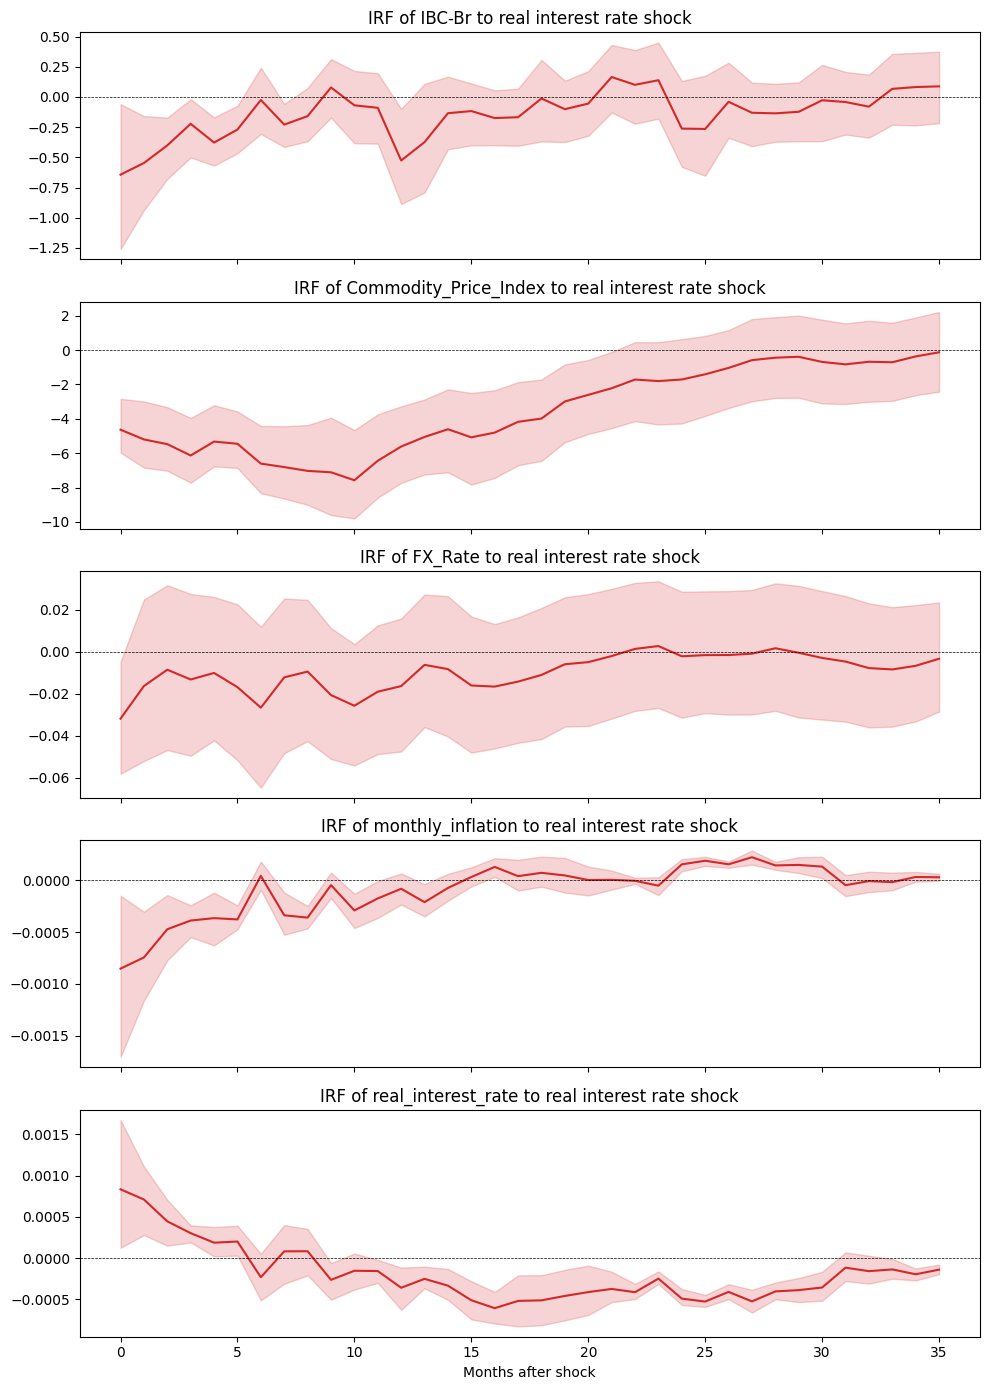

In [69]:


mean_irfs = accepted_irfs.mean(axis=0)
percentiles = np.percentile(accepted_irfs, [5, 95], axis=0)
h = np.arange(horizon)

fig, axs = plt.subplots(len(variables), 1, figsize=(10, 14), sharex=True)
for i, var in enumerate(variables):
    axs[i].plot(h, mean_irfs[:, i], color="#d62728", label='Mean IRF')
    axs[i].fill_between(h, percentiles[0][:, i], percentiles[1][:, i], color="#d62728", alpha=0.2)
    axs[i].axhline(0, color='black', linewidth=0.5, linestyle='--')
    axs[i].set_title(f"IRF of {var} to real interest rate shock")
plt.xlabel("Months after shock")
plt.tight_layout()
plt.show()



FEVD Summary (Real Interest Rate Shock):
   Horizon  IBC-Br  Commodity_Price_Index  FX_Rate  monthly_inflation  \
0        2  0.0145                 0.9855      0.0                0.0   
1        6  0.0065                 0.9935      0.0                0.0   
2       12  0.0027                 0.9973      0.0                0.0   
3       18  0.0029                 0.9971      0.0                0.0   
4       24  0.0028                 0.9972      0.0                0.0   
5       36  0.0031                 0.9969      0.0                0.0   

   real_interest_rate  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  
5                 0.0  


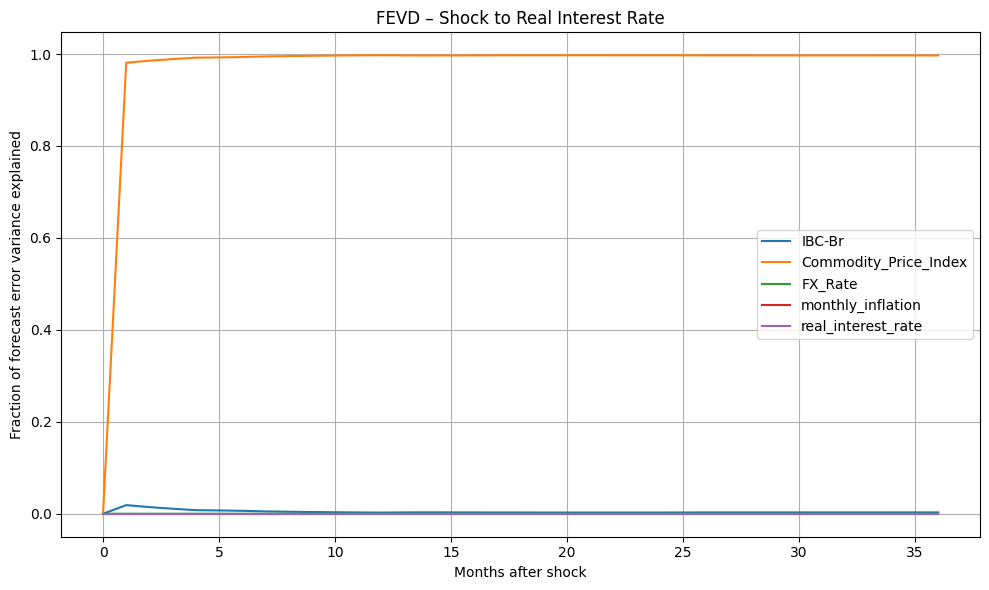

In [70]:

horizon = 37

# 
shock_irfs = accepted_irfs.mean(axis=0)[:, :, np.newaxis]  # shape [horizon, variables, 1]

# 
fevd = np.zeros((horizon, len(variables)))

for h in range(1, horizon):
    numerator = np.cumsum(shock_irfs[:h, :, 0]**2, axis=0)
    denominator = np.sum(numerator, axis=1, keepdims=True)
    fevd[h] = numerator[-1] / denominator[-1]

# 
horizons_to_display = [2, 6, 12, 18, 24, 36]
fevd_summary = pd.DataFrame({'Horizon': horizons_to_display})
for i, var in enumerate(variables):
    fevd_summary[var] = [fevd[h, i] for h in horizons_to_display]

print("\nFEVD Summary (Real Interest Rate Shock):")
print(fevd_summary.round(4))

#
plt.figure(figsize=(10, 6))
for i, var in enumerate(variables):
    plt.plot(range(horizon), fevd[:, i], label=var)

plt.xlabel("Months after shock")
plt.ylabel("Fraction of forecast error variance explained")
plt.title("FEVD – Shock to Real Interest Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Question 3

In this exercise, you are required to reproduce one of the VAR models presented in the September 2012 Inflation Report published by the Central Bank of Brazil (link to report, page 107).

The first VAR model replicates Model I from the report, while the second model partially reproduces Model III.

You must choose the best forecasting model using a model selection criterion.
Use the data starting from January 2000.

#### Data

In [71]:
# Here we use a keyword to search for available time series or browse them manually on the IPEA website
ipea.metadata()

,CODE,NAME,COMMENT,LAST UPDATE,BIG THEME,SOURCE ACRONYM,SOURCE,SOURCE URL,FREQUENCY,MEASURE,UNIT,SERIES STATUS,THEME CODE,COUNTRY,NUMERICA
0,ABATE_ABPEAV,Abate - aves - peso das carcaças,O abate de animais é mensurado por sua quantid...,2025-03-18T13:00:00.673-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Anual,Tonelada,mil,A,1,BRA,True
1,ABATE_ABQUBV,Abate - bovinos - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T13:00:00.673-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Anual,Cabeça,mil,A,1,BRA,True
2,ABATE12_ABPEVA12,Abate - vacas - peso das carcaças,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Tonelada,mil,I,1,BRA,True
3,ABATE12_ABQUBO12,Abate - bois - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Cabeça,mil,A,1,BRA,True
4,ABATE12_ABQUBV12,Abate - bovinos - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Cabeça,mil,A,1,BRA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804,PNADCT_TXPARTCUF_SI,Taxa de participação - sem instrução ou equiva...,"Taxa de participação na força de trabalho, na ...",2025-02-18T12:24:51.957-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Trimestral,(%),None,None,110,None,True
2805,PNAD_IAGRV,Domicílios com insegurança alimentar grave,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.677-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True
2806,PNAD_IALEV,Domicílios com insegurança alimentar leve,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.68-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True
2807,PNAD_IAMOD,Domicílios com insegurança alimentar moderada,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.683-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True


In [80]:
# IPCA series

# Downloading the IPCA series from IPEA
df_ipca = ipea.timeseries('PRECOS12_IPCA12')

# Renaming columns for clarity
df_ipca = df_ipca.rename(columns={
    'RAW DATE': 'date',
    'VALUE (-)': 'IPCA',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Drop unnecessary columns
df_ipca = df_ipca.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Convert 'date' column to datetime (with timezone awareness handling)
df_ipca['date'] = pd.to_datetime(df_ipca['date'], errors='coerce', utc=True)

# Set 'date' as index
df_ipca.set_index('date', inplace=True)

# Remove timezone to make index tz-naive (match other DataFrames)
df_ipca.index = df_ipca.index.tz_convert(None)
df_ipca.index = df_ipca.index.to_period('M').to_timestamp()

# Sort by date
df_ipca = df_ipca.sort_index()

# Calculate monthly inflation from IPCA index
df_ipca['monthly_inflation'] = df_ipca['IPCA'] / df_ipca['IPCA'].shift(1) - 1

df_ipca['monthly_inflation'] = df_ipca['monthly_inflation'].round(5)
df_ipca['IPCA'] = df_ipca['IPCA'].round(5)

In [81]:
# IBC-Br series

# Defining the series code and the date range
series_code = 24363
start_date = '01/01/2000'
end_date = '31/12/2025'

# Building the API URL
url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{series_code}/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'

# Reading the JSON data directly from the API
df_ibcbr = pd.read_json(url)

# Converting the 'date' column to datetime format
df_ibcbr['date'] = pd.to_datetime(df_ibcbr['data'], format='%d/%m/%Y')

# Converting the 'valor' column to numeric type
df_ibcbr['valor'] = pd.to_numeric(df_ibcbr['valor'], errors='coerce')

# Renaming columns for clarity
df_ibcbr = df_ibcbr.rename(columns={
    'valor': 'IBC-Br',
})

# Drop columns
df_ibcbr = df_ibcbr.drop(columns=['data'], errors='ignore')

# Setting 'date' as the index
df_ibcbr.set_index('date', inplace=True)
df_ibcbr.index = df_ibcbr.index.to_period('M').to_timestamp()

# Calculate monthly variation
df_ibcbr['delta_IBCBR'] = df_ibcbr['IBC-Br'] / df_ibcbr['IBC-Br'].shift(1) - 1

df_ibcbr['IBC-Br'] = df_ibcbr['IBC-Br'].round(5)
df_ibcbr['delta_IBCBR'] = df_ibcbr['delta_IBCBR'].round(5)

In [82]:
# SELIC Acum series

# Downloading the SELIC series from IPEA
df_selic = ipea.timeseries('BM12_TJOVER12')

# Renaming columns for clarity
df_selic = df_selic.rename(columns={
    'RAW DATE': 'date',
    'VALUE ((% a.m.))': 'SELIC',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Dropping unnecessary columns
df_selic = df_selic.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Converting 'date' column to datetime (handling timezone if needed)
df_selic['date'] = pd.to_datetime(df_selic['date'], errors='coerce', utc=True)

# Setting 'date' as the index
df_selic.set_index('date', inplace=True)

# Removing timezone to make the index tz-naive
df_selic.index = df_selic.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_selic.index = df_selic.index.to_period('M').to_timestamp()

# Sorting the DataFrame by date
df_selic = df_selic.sort_index()

# Convert SELIC to decimal
df_selic['selic_dec'] = df_selic['SELIC'] / 100

df_selic['SELIC'] = df_selic['SELIC'].round(5)
df_selic['selic_dec'] = df_selic['selic_dec'].round(5)


In [83]:
# Commodity price index series

commodity_code = 27574
start_date = '01/01/2000'
end_date = '31/12/2025'

# Building the API URL
url_commodity = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{commodity_code}/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'

# Reading the data from the API
df_commodity = pd.read_json(url_commodity)

# Converting 'data' to datetime and 'valor' to numeric
df_commodity['data'] = pd.to_datetime(df_commodity['data'], format='%d/%m/%Y', utc=True)
df_commodity['valor'] = pd.to_numeric(df_commodity['valor'], errors='coerce')

# Renaming columns for clarity
df_commodity = df_commodity.rename(columns={'data': 'date', 'valor': 'Commodity_Price_Index'})

# Setting date as index
df_commodity.set_index('date', inplace=True)

# Removing timezone to make index tz-naive
df_commodity.index = df_commodity.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_commodity.index = df_commodity.index.to_period('M').to_timestamp()

# Sorting by date
df_commodity = df_commodity.sort_index()


# Calculate monthly inflation from IPCA index
df_commodity['monthly_Commodity_inflation'] = df_commodity['Commodity_Price_Index'] / df_commodity['Commodity_Price_Index'].shift(1) - 1

df_commodity['Commodity_Price_Index'] = df_commodity['Commodity_Price_Index'].round(5)
df_commodity['monthly_Commodity_inflation'] = df_commodity['monthly_Commodity_inflation'].round(5)


In [84]:
# Exchange rate series code (Dollar - commercial rate, selling)

# Downloading the series from IPEA
df_fx = ipea.timeseries('PAN12_ERV12')

# Renaming columns for clarity
df_fx = df_fx.rename(columns={
    'RAW DATE': 'date',
    'VALUE (R$)': 'FX_Rate',  # Corrigido! Estava escrito 'SELIC' por engano
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Dropping unnecessary columns
df_fx = df_fx.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Converting 'date' to datetime with timezone handling
df_fx['date'] = pd.to_datetime(df_fx['date'], errors='coerce', utc=True)

# Setting 'date' as index
df_fx.set_index('date', inplace=True)

# Removing timezone to make index tz-naive
df_fx.index = df_fx.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_fx.index = df_fx.index.to_period('M').to_timestamp()

# Sorting by date
df_fx = df_fx.sort_index()

# Calculate monthly inflation from IPCA index
df_fx['delta_FX_Rate'] = df_fx['FX_Rate'] / df_fx['FX_Rate'].shift(1) - 1

df_fx['FX_Rate'] = df_fx['FX_Rate'].round(5)
df_fx['delta_FX_Rate']  = df_fx['delta_FX_Rate'] .round(5)

In [85]:
df = df_ibcbr.join([df_ipca, df_selic, df_commodity, df_fx], how='inner')

In [86]:
# Calculate real interest rate using exact Fisher formula
df['real_interest_rate'] = (1 + df['selic_dec']) / (1 + df['monthly_inflation']) - 1

df['real_interest_rate']  = df['real_interest_rate'].round(5)

In [87]:
# Select the variables of interest for the VAR
vars_var = df[['monthly_inflation', 'real_interest_rate', 'Commodity_Price_Index', 'IBC-Br', 'FX_Rate']]

# Check how many missing values there are in each column
print(vars_var.isna().sum())

monthly_inflation        0
real_interest_rate       0
Commodity_Price_Index    0
IBC-Br                   0
FX_Rate                  0
dtype: int64


In [110]:
cols_var1 = ['monthly_inflation', 'Commodity_Price_Index', 'FX_Rate', 'real_interest_rate']
df_var1 = df[cols_var1].dropna()


last_date = df_var1.index[-1]
cutoff = df_var1.index[-13]

train_data = df_var1.loc[:cutoff]

target_date = pd.to_datetime("2025-12-01")


start_forecast_date = cutoff + pd.DateOffset(months=1)
n_steps = (target_date.year - start_forecast_date.year) * 12 + (target_date.month - start_forecast_date.month) + 1
print(f"Forecasting {n_steps} months ahead.")


Forecasting 22 months ahead.


In [111]:

model = VAR(train_data)
results_train = model.fit(12)


In [112]:

forecast_input = train_data.values[-12:]
forecast = results_train.forecast(y=forecast_input, steps=n_steps)

forecast_index = pd.date_range(start=start_forecast_date, periods=n_steps, freq='MS')

forecast_df = pd.DataFrame(forecast, columns=results_train.names, index=forecast_index)

forecast_prices_livres = forecast_df['monthly_inflation']


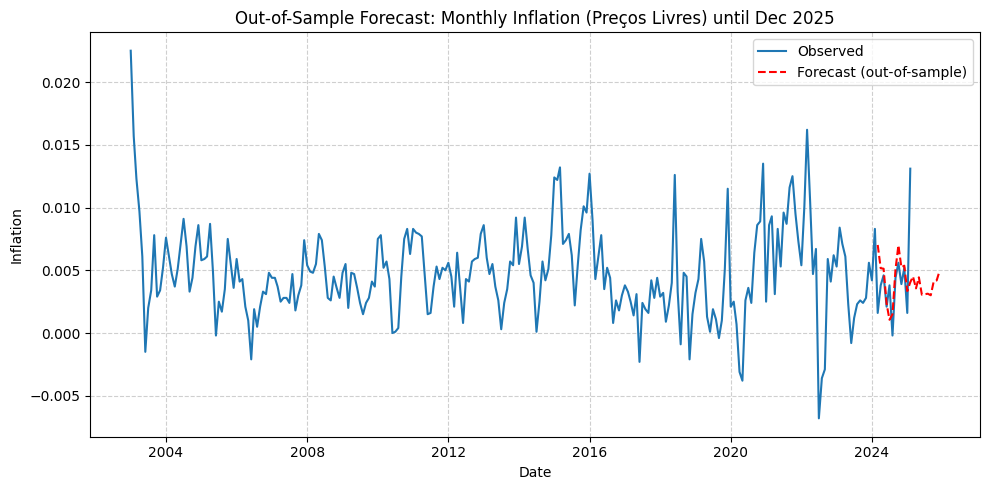

In [113]:


plt.figure(figsize=(10, 5))
plt.plot(df_var1['monthly_inflation'], label='Observed')
plt.plot(forecast_prices_livres, label='Forecast (out-of-sample)', linestyle='--', color='red')
plt.title('Out-of-Sample Forecast: Monthly Inflation (Preços Livres) until Dec 2025')
plt.xlabel('Date')
plt.ylabel('Inflation')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [117]:
cols_var3 = ['monthly_inflation', 'IBC-Br', 'real_interest_rate']
df_var3 = df[cols_var3].dropna()

from statsmodels.tsa.seasonal import seasonal_decompose

def seasonally_adjust(series):
    result = seasonal_decompose(series, model='additive', period=12)
    return series - result.seasonal

df_var3_sa = df_var3.apply(seasonally_adjust)


In [118]:

cutoff = df_var3_sa.index[-13]


train_data = df_var3_sa.loc[:cutoff]


target_date = pd.to_datetime("2025-12-01")
start_forecast_date = cutoff + pd.DateOffset(months=1)

n_steps = (target_date.year - start_forecast_date.year) * 12 + (target_date.month - start_forecast_date.month) + 1
print(f"Forecasting {n_steps} months ahead.")



Forecasting 22 months ahead.


In [119]:
from statsmodels.tsa.api import VAR

model = VAR(train_data)
results = model.fit(3)


In [120]:

forecast_input = train_data.values[-3:]
forecast = results.forecast(y=forecast_input, steps=n_steps)


forecast_index = pd.date_range(start=start_forecast_date, periods=n_steps, freq='MS')


forecast_df = pd.DataFrame(forecast, columns=results.names, index=forecast_index)


forecast_prices_livres = forecast_df['monthly_inflation']


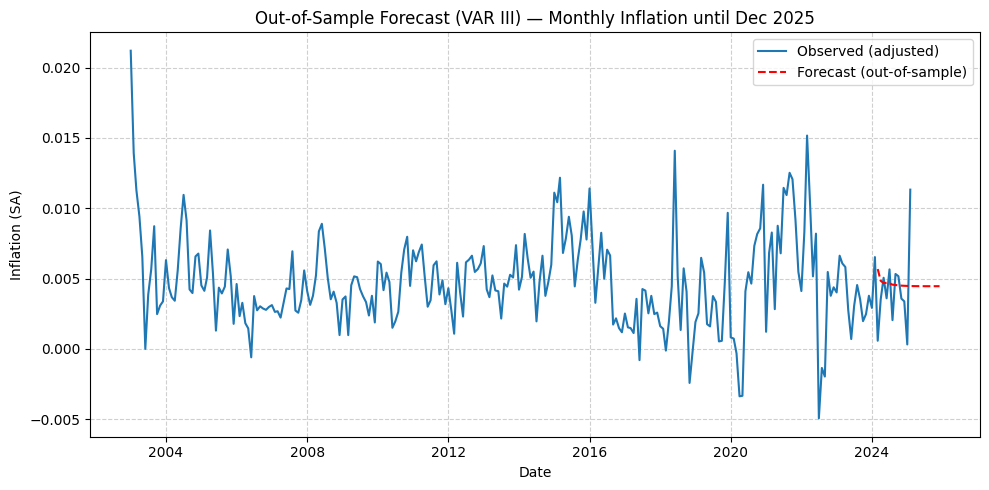

In [121]:


plt.figure(figsize=(10, 5))
plt.plot(df_var3_sa['monthly_inflation'], label='Observed (adjusted)')
plt.plot(forecast_prices_livres, label='Forecast (out-of-sample)', linestyle='--', color='red')
plt.title('Out-of-Sample Forecast (VAR III) — Monthly Inflation until Dec 2025')
plt.xlabel('Date')
plt.ylabel('Inflation (SA)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
